## PCA analysis of two lung cancer sets

Here we are perfoming a PCA of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their principal components.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import urllib.request
import tarfile

import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)
        


def get_data(path,url,file):
    try:
        df = pd.read_csv(path)
    except:
#        urllib.request.urlretrieve(url, "my.tar.gz")
        track_dl(url, "my.tar.gz")
        tf = tarfile.open("my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(path)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    return df

luad = get_data("luad.tsv", 'http://download.cbioportal.org/luad_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
lusc = get_data("lusc.tsv", 'http://download.cbioportal.org/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")

We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0.

In [2]:
combined = pd.concat([lusc, luad], axis=1, sort=False)
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
combined = pd.DataFrame(data=np.log2(combined),index=combined.index,columns=combined.columns)

Transform the data with PCA.

In [3]:
from sklearn.decomposition import PCA
model = PCA(n_components=2) 
model.fit(combined.T) 
combined_2D = model.transform(combined.T)

Project the resuts of the PCA into two matrices, one describing the PCs of the patients, one for the genes. 

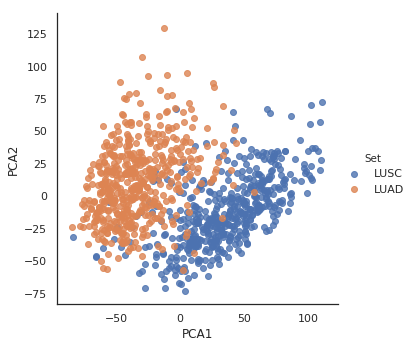

In [4]:
transformed_patients = pd.DataFrame(data=combined_2D,columns=["PCA1","PCA2"],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])
transformed_genes=pd.DataFrame(data=model.components_.T, index = combined.index, columns = ["PCA1","PCA2"])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

sns.lmplot("PCA1", "PCA2", hue='Set', data=transformed_patients, fit_reg=False)

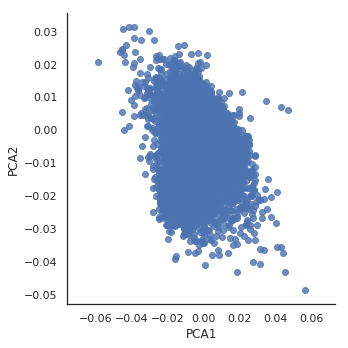

In [5]:
sns.lmplot("PCA1", "PCA2", data=transformed_genes, fit_reg=False)

In [6]:
transformed_genes.idxmax(axis=0)

PCA1    KRT17
PCA2     RGL3
dtype: object

In [7]:
transformed_genes.idxmin(axis=0)

PCA1    SFTPB
PCA2    KRT17
dtype: object